# Twitter Sentiment Analysis on Product Reviews

## Import Libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Dataset


In [55]:
import pandas as pd

# Example path to a dataset in Google Drive
file_path = '/content/drive/My Drive/Reviews.csv'

# Load dataset into a Pandas DataFrame
df = pd.read_csv(file_path)


In [56]:
# Load the dataset (assuming you have downloaded and uploaded the file to your environment)

df = df[['Text', 'Score']]
df.columns = ['review', 'sentiment']
df = df[df['sentiment'] != 3]
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x > 3 else 0)
print(df.head())


                                              review  sentiment
0  I have bought several of the Vitality canned d...          1
1  Product arrived labeled as Jumbo Salted Peanut...          0
2  This is a confection that has been around a fe...          1
3  If you are looking for the secret ingredient i...          0
4  Great taffy at a great price.  There was a wid...          1


In [57]:
# Assuming 'df' is your pandas DataFrame
print("Shape of the DataFrame:")
print(df.shape)


Shape of the DataFrame:
(525814, 2)


#Data Visualization


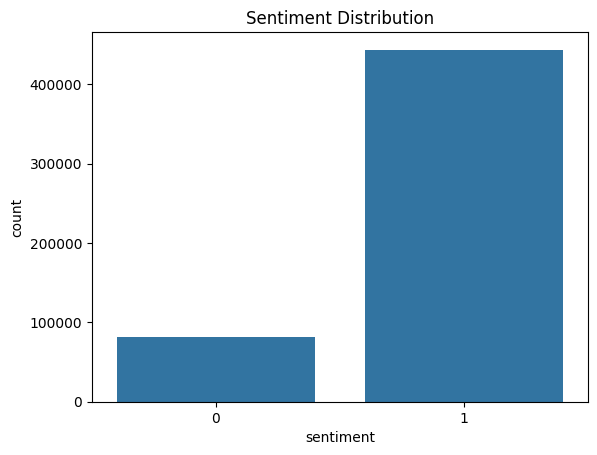

In [58]:
# Check if the dataset is balanced
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()


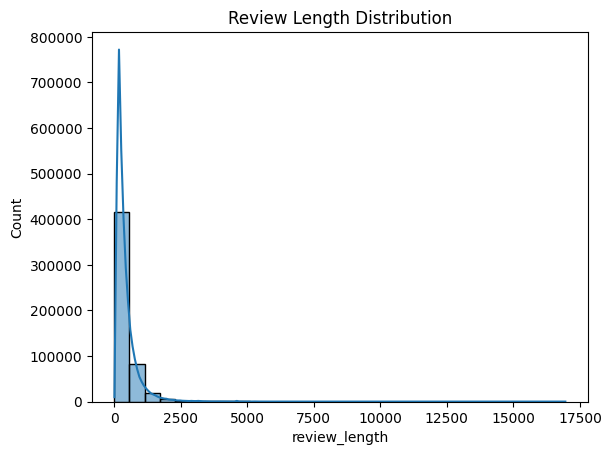

In [59]:
# Bar graph of review lengths
df['review_length'] = df['review'].apply(len)
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Review Length Distribution')
plt.show()



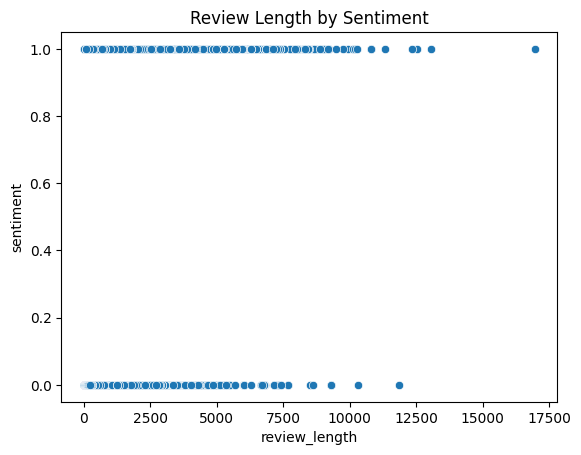

In [60]:
# Scatter plot of review lengths by sentiment
sns.scatterplot(x='review_length', y='sentiment', data=df)
plt.title('Review Length by Sentiment')
plt.show()

## Data Preprocessing

In [61]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# Take 7000 records from the dataset
df = df.head(7000)

# Function to clean text and tokenize
def clean_and_tokenize(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove @ mentions
    text = re.sub(r'#', '', text)        # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove digits
    text = text.lower()                  # Convert to lowercase
    tokens = word_tokenize(text)         # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Apply the function to each row in the 'review' column and create a new column 'cleaned_tokens'
df['cleaned_tokens'] = df['review'].apply(clean_and_tokenize)

# Print the DataFrame head to check the result
print(df.head())


                                              review  sentiment  \
0  I have bought several of the Vitality canned d...          1   
1  Product arrived labeled as Jumbo Salted Peanut...          0   
2  This is a confection that has been around a fe...          1   
3  If you are looking for the secret ingredient i...          0   
4  Great taffy at a great price.  There was a wid...          1   

   review_length                                     cleaned_tokens  
0            263  [bought, several, vitality, canned, dog, food,...  
1            190  [product, arrived, labeled, jumbo, salted, pea...  
2            509  [confection, around, centuries, light, pillowy...  
3            219  [looking, secret, ingredient, robitussin, beli...  
4            140  [great, taffy, great, price, wide, assortment,...  


## Text Vectorization

In [62]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokenized text back to string format for TfidfVectorizer
df['cleaned_tokens_str'] = df['cleaned_tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Fit-transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_tokens_str'])

# Print the shape of tfidf_matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

# Optional: Print feature names (words) from tfidf_vectorizer
print("Features (words):", tfidf_vectorizer.get_feature_names_out())

# Optional: Convert tfidf_matrix to a DataFrame (for visualization or further processing)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())


Shape of TF-IDF matrix: (7000, 1000)
Features (words): ['able' 'absolutely' 'acid' 'actual' 'actually' 'add' 'added' 'adding'
 'addition' 'admit' 'advertised' 'aftertaste' 'ago' 'agree' 'air'
 'allergic' 'allergies' 'almond' 'almost' 'along' 'already' 'also'
 'alternative' 'although' 'always' 'amazing' 'amazon' 'amazoncom' 'amount'
 'another' 'anymore' 'anyone' 'anything' 'anyway' 'anywhere' 'apple'
 'area' 'arent' 'aroma' 'around' 'arrived' 'artificial' 'ask' 'ate'
 'available' 'avoid' 'away' 'awesome' 'awful' 'baby' 'back' 'bad' 'bag'
 'bags' 'baked' 'baking' 'balance' 'bar' 'bars' 'based' 'basically'
 'batch' 'bbq' 'bean' 'beans' 'beat' 'become' 'beef' 'believe' 'best'
 'better' 'beverage' 'big' 'bigger' 'biscuits' 'bisquick' 'bit' 'bite'
 'bitter' 'black' 'bland' 'blend' 'blood' 'blue' 'body' 'bold' 'bottle'
 'bottles' 'bottom' 'bought' 'bowl' 'box' 'boxes' 'br' 'brand' 'brands'
 'bread' 'break' 'breakfast' 'brew' 'brewing' 'bring' 'broken' 'brought'
 'brown' 'bulk' 'butter' 'buy' 

## Split into train and test

In [63]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)

# Print shapes of the resulting datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (5600, 1000)
Shape of X_test: (1400, 1000)
Shape of y_train: (5600,)
Shape of y_test: (1400,)


# Model Training using Machine Learning models

## 1. Naive Bayes


In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred)
nb_recall = recall_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)
nb_confusion_matrix = confusion_matrix(y_test, nb_pred)

print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Precision:", nb_precision)
print("Naive Bayes Recall:", nb_recall)
print("Naive Bayes F1 Score:", nb_f1)
print("Naive Bayes Confusion Matrix:\n", nb_confusion_matrix)



Naive Bayes Accuracy: 0.8457142857142858
Naive Bayes Precision: 0.8451519536903039
Naive Bayes Recall: 0.9982905982905983
Naive Bayes F1 Score: 0.9153605015673981
Naive Bayes Confusion Matrix:
 [[  16  214]
 [   2 1168]]


## 2. Logistic Regression


In [65]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_confusion_matrix = confusion_matrix(y_test, lr_pred)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression Precision:", lr_precision)
print("Logistic Regression Recall:", lr_recall)
print("Logistic Regression F1 Score:", lr_f1)
print("Logistic Regression Confusion Matrix:\n", lr_confusion_matrix)

Logistic Regression Accuracy: 0.8728571428571429
Logistic Regression Precision: 0.8707025411061285
Logistic Regression Recall: 0.9957264957264957
Logistic Regression F1 Score: 0.9290271132376396
Logistic Regression Confusion Matrix:
 [[  57  173]
 [   5 1165]]


## 3. Support Vector Machine


In [66]:
# Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_confusion_matrix = confusion_matrix(y_test, svm_pred)

print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1 Score:", svm_f1)
print("SVM Confusion Matrix:\n", svm_confusion_matrix)

SVM Accuracy: 0.87
SVM Precision: 0.8692077727952168
SVM Recall: 0.994017094017094
SVM F1 Score: 0.9274322169059012
SVM Confusion Matrix:
 [[  55  175]
 [   7 1163]]


In [67]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_pred)

# Print evaluation metrics and confusion matrix
print("Random Forest - Accuracy:", rf_accuracy)
print("Random Forest - Precision:", rf_precision)
print("Random Forest - Recall:", rf_recall)
print("Random Forest - F1 Score:", rf_f1)
print("Random Forest - Confusion Matrix:\n", rf_conf_matrix)


Random Forest - Accuracy: 0.8564285714285714
Random Forest - Precision: 0.8575645756457565
Random Forest - Recall: 0.9931623931623932
Random Forest - F1 Score: 0.9203960396039604
Random Forest - Confusion Matrix:
 [[  37  193]
 [   8 1162]]


In [68]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# Calculate evaluation metrics
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)
gb_conf_matrix = confusion_matrix(y_test, gb_pred)

# Print evaluation metrics and confusion matrix
print("Gradient Boosting - Accuracy:", gb_accuracy)
print("Gradient Boosting - Precision:", gb_precision)
print("Gradient Boosting - Recall:", gb_recall)
print("Gradient Boosting - F1 Score:", gb_f1)
print("Gradient Boosting - Confusion Matrix:\n", gb_conf_matrix)


Gradient Boosting - Accuracy: 0.8585714285714285
Gradient Boosting - Precision: 0.8594674556213018
Gradient Boosting - Recall: 0.9931623931623932
Gradient Boosting - F1 Score: 0.9214908802537668
Gradient Boosting - Confusion Matrix:
 [[  40  190]
 [   8 1162]]


In [69]:
# AdaBoost Classifier
ab_model = AdaBoostClassifier(random_state=42)
ab_model.fit(X_train, y_train)
ab_pred = ab_model.predict(X_test)

# Calculate evaluation metrics
ab_accuracy = accuracy_score(y_test, ab_pred)
ab_precision = precision_score(y_test, ab_pred)
ab_recall = recall_score(y_test, ab_pred)
ab_f1 = f1_score(y_test, ab_pred)
ab_conf_matrix = confusion_matrix(y_test, ab_pred)

# Print evaluation metrics and confusion matrix
print("AdaBoost - Accuracy:", ab_accuracy)
print("AdaBoost - Precision:", ab_precision)
print("AdaBoost - Recall:", ab_recall)
print("AdaBoost - F1 Score:", ab_f1)
print("AdaBoost - Confusion Matrix:\n", ab_conf_matrix)


AdaBoost - Accuracy: 0.8621428571428571
AdaBoost - Precision: 0.8789759503491078
AdaBoost - Recall: 0.9683760683760684
AdaBoost - F1 Score: 0.9215128100854005
AdaBoost - Confusion Matrix:
 [[  74  156]
 [  37 1133]]


# Conclusion

Logistic Regression achieved the highest accuracy of 87.2%

##Hyperparameter tuning

In [70]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE


In [71]:
# Logistic Regression Classifier
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Define parameters for Grid Search
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],   # Regularization penalty
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],               # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Optimization algorithm
    'max_iter': [100, 200, 300]                       # Maximum number of iterations
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid,
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)


In [72]:
# Perform Grid Search to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters found by Grid Search
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
675 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following er

Best Parameters: {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [73]:
# Evaluate the best model on the test set
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics and confusion matrix
print("Best Logistic Regression Model - Accuracy:", accuracy)
print("Best Logistic Regression Model - Precision:", precision)
print("Best Logistic Regression Model - Recall:", recall)
print("Best Logistic Regression Model - F1 Score:", f1)
print("Best Logistic Regression Model - Confusion Matrix:\n", conf_matrix)


Best Logistic Regression Model - Accuracy: 0.8892857142857142
Best Logistic Regression Model - Precision: 0.9096045197740112
Best Logistic Regression Model - Recall: 0.9632478632478633
Best Logistic Regression Model - F1 Score: 0.9356579493565794
Best Logistic Regression Model - Confusion Matrix:
 [[ 118  112]
 [  43 1127]]


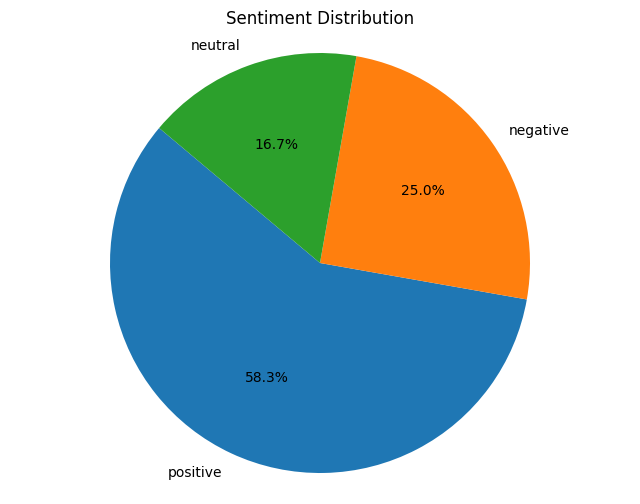

In [80]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Example sentiment data (replace with your actual sentiment data)
sentiments = ['positive', 'negative', 'neutral']
counts = [350, 150, 100]  # Example counts for each sentiment category

# Pie chart for sentiment distribution
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=sentiments, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




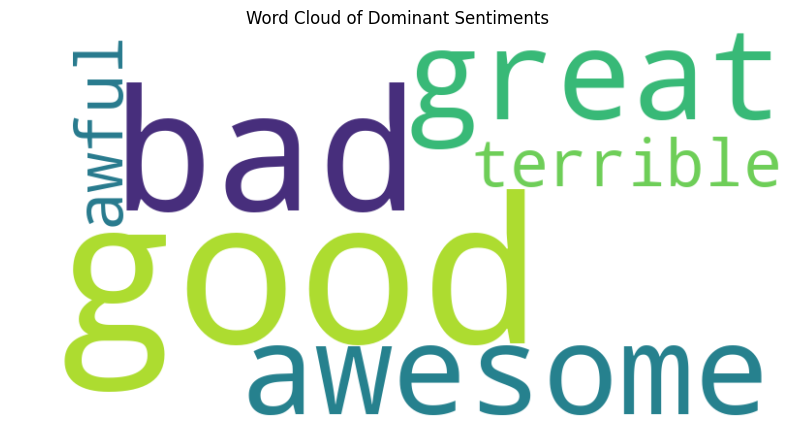

In [78]:
# Example text data (replace with your actual text data)
text_data = "good great awesome bad terrible awful good bad good"

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display word cloud using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Dominant Sentiments')
plt.show()